# Working with TRIS Data # 
This notebook attempts to visualize the TRIS data, replicate some of their methods, and look at disk/halo models that are consistent with the galactic component of their data

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner
import glob


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

import ModelDefinitions as MD
import LogProb as LP
import const as const
import TRIS_vals as tris
from const import *
from TRIS_vals import *
import importlib
importlib.reload(LP);
importlib.reload(MD);
importlib.reload(const);
importlib.reload(tris);

from tqdm import tqdm

/home/nitika/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Sigma is 584.819674 arcmin (0.170117 rad) 
-> fwhm is 1377.145090 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 584.529302 arcmin (0.170033 rad) 
-> fwhm is 1376.461318 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/nitika/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Sigma is 570.972611 arcmin (0.166089 rad) 
-> fwhm is 1344.537750 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/nitika/GradSchool/Research/Radio_Background/radio-background/ModelDefinitions.py:54: RuntimeWarning: invalid value encountered in arcsin
  B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))


In [36]:
file = 'TRIS600_test.npz'

samples_ = np.load(file)['samples']
samples = np.array(samples_[:,800:,:])
print(samples.shape)

# just doing this cut by eye unfortunately
ndim = samples.shape[2]
idx = np.where((np.array(samples[:,0,0]) < 2.24))
samples = np.delete(samples, idx, 0)

samples_reshape = samples.reshape((-1, ndim))

(50, 9200, 5)


(48, 9200, 5)
(441600, 5)


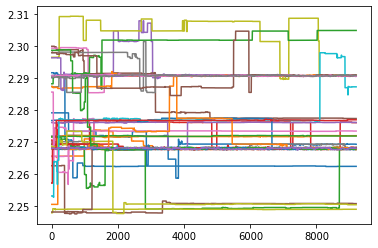

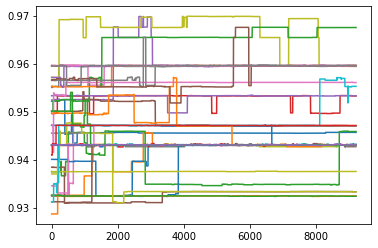

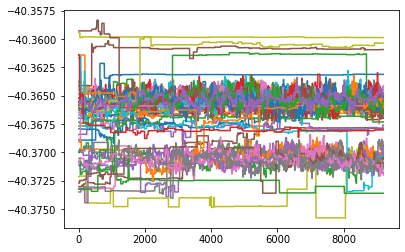

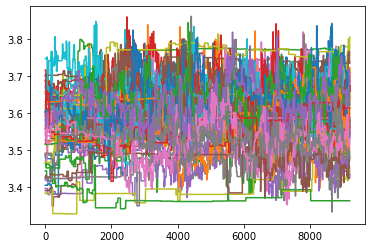

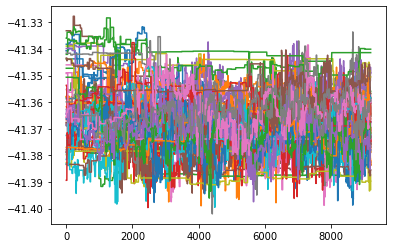

In [37]:
print(samples.shape)
print(samples_reshape.shape)
for j in range(samples.shape[2]):
    plt.figure()
    for i in range(samples.shape[0]):
            plt.plot(samples[i,:,j])
    

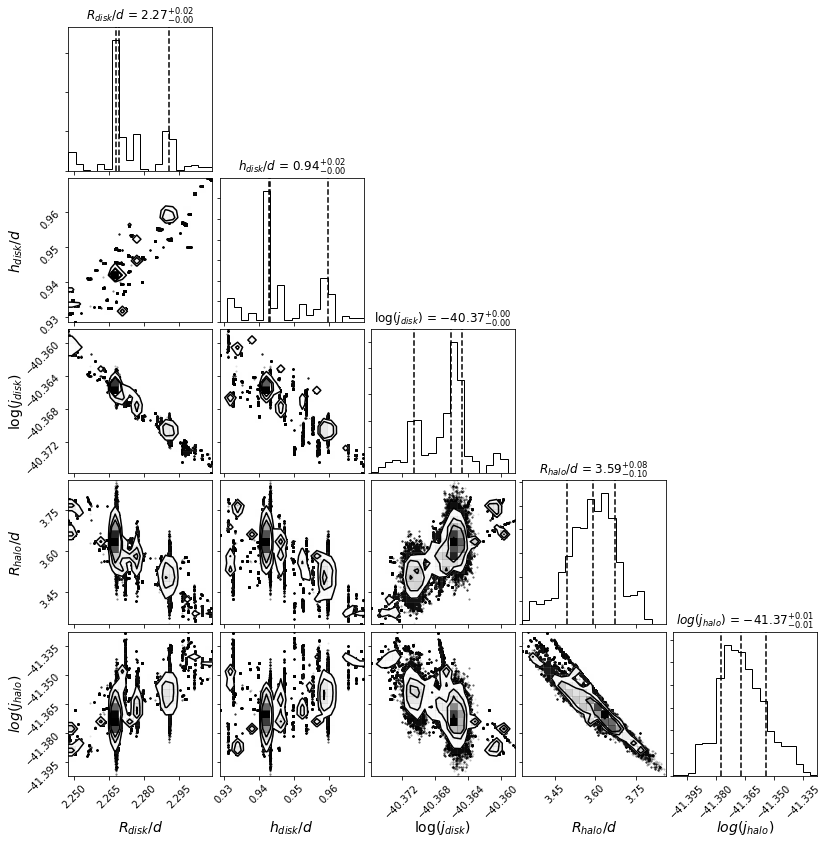

In [38]:
fig = corner.corner(samples_reshape, 
                    labels=["$R_{disk} / d$","$h_{disk} /d$","log($j_{disk}$)",
                             "$R_{halo} /d$","$log(j_{halo}$)", "$sig_{sys}$"],
                    label_kwargs={"fontsize": 14}, show_titles=True, 
                    #title_kwargs={"fontsize": 16, "position":(0.65,1)},
                    quantiles=[0.16,0.5,0.84]
                   )

plt.savefig('TRIS600_5pcorner.png', bbox_inches='tight')

[2.2072111710065716, 0.9304188793806155, -40.34855297081369, 4.662570991739223, -41.50155302407653, 0.8148444064245859]


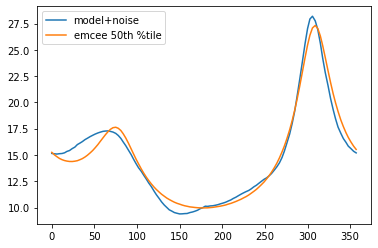

In [18]:
# for simulated data

param_50 = []
for i in range(samples.shape[-1]):
    param_50.append(np.percentile(samples_reshape[:,i], 50))
    
print(param_50)
    

# print(param_50)
# print(LP.TRIS_psim)
# print(np.array(param_50) - np.array(LP.TRIS_psim))

plt.figure()
plt.plot(TRIS_ra[0.6e9], TRIS_Tb[0.6e9], label='model+noise')
plt.plot(TRIS_ra[0.6e9], LP.TRISmodel(param_50, 0.6e9), label='emcee 50th %tile')
plt.legend()_

In [19]:
# for real data
n = len(samples_reshape)
T600_mcmc = np.zeros((n, len(TRIS_ra[0.6e9])))

for i in tqdm(range(n)):
    T600_mcmc[i] = LP.TRISmodel(samples_reshape[i], 0.6e9)


  0%|          | 833/450800 [00:02<23:24, 320.29it/s]/home/nitika/GradSchool/Research/Radio_Background/radio-background/ModelDefinitions.py:54: RuntimeWarning: invalid value encountered in arcsin
  B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))
100%|██████████| 450800/450800 [20:36<00:00, 364.60it/s]


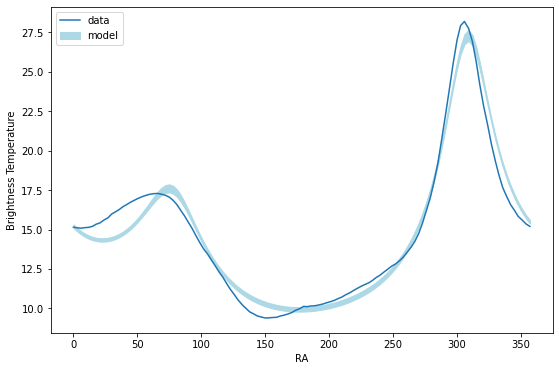

In [30]:
mean600 = np.mean(T600_mcmc, axis=0)
std600 = np.std(T600_mcmc, axis=0)

plt.figure(figsize=(9,6))
plt.plot(TRIS_ra[0.6e9], TRIS_Tb[0.6e9], label='data')
plt.fill_between(TRIS_ra[0.6e9], mean600-std600, mean600+std600, color='lightblue', label='model')
#plt.plot(TRIS_ra[0.6e9], mean600)
plt.xlabel('RA')
plt.ylabel('Brightness Temperature')
plt.legend(loc='upper left')
plt.savefig('TRIS600_6ptest.png', bbox_inches='tight')